### Extracting the files

In [1]:
!pip install pyunpack
!pip install patool
# Extracting the .7z file, as the given file is in .7z format and the notebook is running on kaggle
import os
from pyunpack import Archive
os.system('apt-get install p7zip')
import shutil
if not os.path.exists('/kaggle/working/train/'):
    '''If already, some file is created don't make it
    '''
    os.makedirs('/kaggle/working/train/')

# Extracting the .7z file 
Archive('../input/tensorflow-speech-recognition-challenge/train.7z').extractall('/kaggle/working/train/')


# Checking the number of each file
import os
path = os.listdir('./train/train/audio/')
size = {}
for i in path:
      size[i] = len(os.listdir('./train/train/audio/'+i))
print(size)

     |████████████████████████████████| 77 kB 937 kB/s 
{'stop': 2380, 'cat': 1733, 'left': 2353, 'up': 2375, 'bird': 1731, 'five': 2357, 'bed': 1713, 'house': 1750, 'marvin': 1746, 'yes': 2377, 'two': 2373, 'on': 2367, 'wow': 1745, 'six': 2369, 'four': 2372, 'sheila': 1734, 'tree': 1733, 'zero': 2376, 'dog': 1746, 'down': 2359, 'right': 2367, 'off': 2357, 'go': 2372, 'no': 2375, 'three': 2356, '_background_noise_': 7, 'happy': 1742, 'seven': 2377, 'nine': 2364, 'one': 2370, 'eight': 2352}


## a. Making the labelled dataset

### 1. What do we have now?

Basically, we have some folders containing the audio files, in which most of them are of fixed duration (i.e of one sec), however, many of them are of the duration less than 1 sec, and the audio dataset is basically taken in a quiet place,however in real life scenario, there is a bit of background noise, and we would be mixing some percentage of background noise to the original model, to make it more robust


In [2]:
# The total categories of labels
print("The total labels are: ",len(os.listdir('./train/train/audio'))-1)  # excluding the _background_noise_

The total labels are:  30


In [3]:
[i for i in os.listdir('./train/train/audio')[:8] if i !='_background_noise_']

['stop', 'cat', 'left', 'up', 'bird', 'five', 'bed', 'house']

In [4]:
import librosa # For loading the audio file

labels_to_consider = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unknown = [i for i in os.listdir('./train/train/audio') if i not in labels_to_consider and i != '_background_noise_' ]

def label_encoder(directory):
    '''
    Input: labels -> list of labels to be considered
           directory -> the folder in which the examples for all the dataset is present
           
    Output : list containing the entry as: (sample,gruop number)
    '''
    i = 0
    label_encoder ={}
    labelled_wave = []
    training_data = []
    for label in labels_to_consider:
        path = os.path.join(directory,label)
        label_encoder[label] = i    # Label to encoder
        print("The current label is: "+str(label)+" of: "+str(i))
        i+=1
        for audio_file in os.listdir(path):
            if audio_file.endswith('.wav'):
                samples, sample_rate = librosa.load(os.path.join(os.path.join(directory,label),audio_file))
                samples = librosa.resample(samples,sample_rate,8000)
            if len(samples)!=8000:
                continue
            else:
                labelled_wave.append([samples,label])
                training_data.append(samples)
    for label in unknown:
                print("The current label is: "+str("unknown"+" of: "+str(i)))
                label_encoder['unknown'] = i
                path = os.path.join(directory,label)
                for audio_file in os.listdir(path):
                    if audio_file.endswith('.wav'):
                        samples, sample_rate = librosa.load(os.path.join(os.path.join(directory,label),audio_file))
                        samples = librosa.resample(samples,sample_rate,8000)
                    if len(samples)!=8000:
                        continue
                    else:
                        labelled_wave.append([samples,'unknown'])
                        training_data.append(samples)
    return labelled_wave,training_data,label_encoder
labelled_wave,training_data,label_encoder = label_encoder('./train/train/audio')

The current label is: yes of: 0
The current label is: no of: 1
The current label is: up of: 2
The current label is: down of: 3
The current label is: left of: 4
The current label is: right of: 5
The current label is: on of: 6
The current label is: off of: 7
The current label is: stop of: 8
The current label is: go of: 9
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current label is: unknown of: 10
The current l

In [5]:
import numpy as np
import random
def get_random_noise():
    ''' This function will be useful for getting the random noise
    '''
    audios = os.listdir('./train/train/audio/_background_noise_')
    noise = random.randint(0,len(audios)-1)
    noise,sr = librosa.load('./train/train/audio/_background_noise_/'+audios[noise])
    noise = librosa.resample(noise,sr,8000)
    start =random.randint(0,noise.shape[0]-8000-1)
    return noise[start:start+8000]


def mix_audio(data,ratio = 0.1):
    ''' This function will mix the original audio with the background noise
    '''
    noise = get_random_noise()
    final_data = []
    for i,j in enumerate(data):
        final_data.append(j + (ratio*noise))
    return final_data
final_data = mix_audio(training_data)

In [6]:
labels = [i[1] for i in labelled_wave]
def remove_not_equal_length(data,labels):
    
    '''If some array has some inadequate length, we would remove it
    '''
    final_data = []
    for i,j in zip(data,labels):
        if len(i)!=8000:
            continue
        else:
            final_data.append([i,j])
    return final_data
dataset = remove_not_equal_length(final_data,labels)

In [7]:
# Traininng data = wav_file
# Labels = target
wave_file = [i[0] for i in dataset]
wave_file = np.reshape(np.array(wave_file),(-1,8000,1))
target = [label_encoder[i[1]] for i in dataset]
target = np.reshape(target,(-1,1))

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(wave_file,target,test_size= 0.15,random_state=98,shuffle=True)

In [9]:
import keras
y_train = keras.utils.to_categorical(y_train, len(set(labels))+1)
y_test = keras.utils.to_categorical(y_test, len(set(labels))+1)

In [10]:
len(set(labels))

11

In [11]:
from tensorflow.keras import layers,Input
import tensorflow as tf

def model(parameters,input_shape):
    
    '''Return the model, containing the parameters,
    parameters would be a dictionary
    '''
    
    lr = parameters['lr']
    drop_out_rate = parameters['drop_out']
    input_tensor = Input(shape=(input_shape))
    x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(drop_out_rate)(x)
    x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(drop_out_rate)(x)
    x = layers.Conv1D(31, 5, padding='valid', activation='relu', strides=1)(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(drop_out_rate)(x)
    x = layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1)(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(drop_out_rate)(x)
    x = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1)(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(drop_out_rate)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(drop_out_rate)(x)
    output_tensor = layers.Dense(len(set(labels))+1, activation='softmax')(x)
    model = tf.keras.Model(input_tensor, output_tensor)
    return model
parameters = {'lr':0.001,'drop_out':0.2}
input_shape = (8000,1)
conv_model = model(parameters,input_shape)

conv_model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr = parameters['lr']),
             metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7990, 8)           96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3995, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 3995, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3989, 16)          912       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1994, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1994, 16)          0     

In [12]:
history = conv_model.fit(X_train,y_train,validation_data = (X_test,y_test),batch_size=256,epochs=100,verbose=1)

Epoch 1/100
194/194 [==============================] - 19s 70ms/step - loss: 1.6154 - accuracy: 0.6152 - val_loss: 1.3919 - val_accuracy: 0.6347
Epoch 2/100
194/194 [==============================] - 13s 65ms/step - loss: 1.3323 - accuracy: 0.6361 - val_loss: 1.1815 - val_accuracy: 0.6512
Epoch 3/100
194/194 [==============================] - 13s 65ms/step - loss: 1.1560 - accuracy: 0.6480 - val_loss: 1.0365 - val_accuracy: 0.6634
Epoch 4/100
194/194 [==============================] - 13s 65ms/step - loss: 1.0319 - accuracy: 0.6683 - val_loss: 0.8964 - val_accuracy: 0.7057
Epoch 5/100
194/194 [==============================] - 12s 64ms/step - loss: 0.9012 - accuracy: 0.7017 - val_loss: 0.8606 - val_accuracy: 0.7226
Epoch 6/100
194/194 [==============================] - 12s 64ms/step - loss: 0.7765 - accuracy: 0.7399 - val_loss: 0.6737 - val_accuracy: 0.7800
Epoch 7/100
194/194 [==============================] - 12s 64ms/step - loss: 0.6972 - accuracy: 0.7690 - val_loss: 0.7079 - val_ac

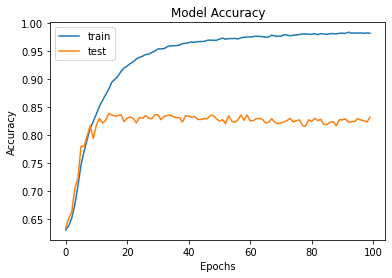

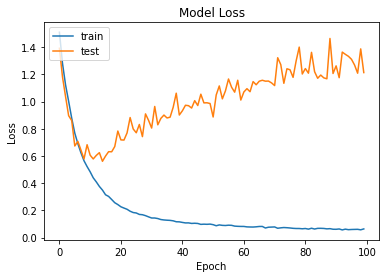

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(['train','test'],loc = 'upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['train','test'],loc = 'upper left')
plt.show()
from tensorflow import keras
keras.models.save_model(conv_model,'speech-recognition.h5')

## Random Forest

In [14]:
training_labels = [np.argmax(i) for i in y_train]
testing_labels = [np.argmax(i) for i in y_test]

In [15]:
train  = X_train.reshape(-1,8000)
test  = X_test.reshape(-1,8000)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42,max_depth = 20)
classifier.fit(train,training_labels)

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=10,
                       random_state=42)

In [17]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(classification_report(testing_labels,classifier.predict(test)))
print("The accuracy score is:",accuracy_score(testing_labels,classifier.predict(test)))
#print("The F! score is:",f1_score(testing_labels,classifier.predict(test)))

              precision    recall  f1-score   support

           0       0.20      0.02      0.04       338
           1       0.16      0.02      0.03       307
           2       0.18      0.01      0.01       300
           3       0.14      0.01      0.02       336
           4       0.24      0.01      0.02       319
           5       0.35      0.02      0.04       306
           6       0.27      0.02      0.04       330
           7       0.33      0.02      0.03       310
           8       0.12      0.01      0.01       324
           9       0.17      0.01      0.01       323
          10       0.64      0.98      0.77      5545

    accuracy                           0.63      8738
   macro avg       0.25      0.10      0.09      8738
weighted avg       0.48      0.63      0.50      8738

The accuracy score is: 0.6271457999542229
